# Pre-processing images

In [1]:
'''
USAGE:
python preprocess_image.py --num-images 1200
'''
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
num_images=int(input("Enter the number of images required for pre-processing"))
print(f"Preprocessing {num_images} from each category...")


# get all the directory paths
dir_paths = os.listdir('ASL\\input\\asl_alphabet_train\\asl_alphabet_train')
dir_paths.sort()
root_path = 'ASL\\input\\asl_alphabet_train\\asl_alphabet_train'


# get --num-images images from each category
for idx, dir_path  in tqdm(enumerate(dir_paths), total=len(dir_paths)):
    all_images = os.listdir(f"{root_path}/{dir_path}")
    os.makedirs(f"ASL/input/preprocessed_image/{dir_path}", exist_ok=True)
    for i in range(num_images): # how many images to preprocess for each category
        # generate a random id between 0 and 2999
        rand_id = (random.randint(0, 2999))
        image = cv2.imread(f"{root_path}/{dir_path}/{all_images[rand_id]}")
        image = cv2.resize(image, (224, 224))
        cv2.imwrite(f"ASL/input/preprocessed_image/{dir_path}/{dir_path}{i}.jpg", image)
print('DONE')


Enter the number of images required for pre-processing1500


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

Preprocessing 1500 from each category...


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [03:11<00:00,  6.62s/it]

DONE


# Creating a csv file with labels and path

In [2]:
'''
USAGE:
python create_csv.py
'''
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
from imutils import paths
# get all the image paths
image_paths = list(paths.list_images('ASL\\input\\preprocessed_image'))
# create a DataFrame 
data = pd.DataFrame()
labels = []
for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
    label = image_path.split(os.path.sep)[-2]
    # save the relative path for mapping image to target
    data.loc[i, 'image_path'] = image_path
    labels.append(label)
labels = np.array(labels)
# one hot encode the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"The first one hot encoded labels: {labels[0]}")
print(f"Mapping the first one hot encoded label to its category: {lb.classes_[0]}")
print(f"Total instances: {len(labels)}")
for i in range(len(labels)):
    index = np.argmax(labels[i])
    data.loc[i, 'target'] = int(index)
# shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)
# save as CSV file
data.to_csv('ASL/input/data.csv', index=False)
# pickle the binarized labels
print('Saving the binarized labels as pickled file')
joblib.dump(lb, 'ASL/output/lb.pkl')
print(data.head(5))



100%|███████████████████████████████████████████████████████████████████████████| 43500/43500 [02:01<00:00, 358.71it/s]


The first one hot encoded labels: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Mapping the first one hot encoded label to its category: A
Total instances: 43500
Saving the binarized labels as pickled file
                                 image_path  target
0   ASL\input\preprocessed_image\O\O543.jpg    14.0
1   ASL\input\preprocessed_image\H\H132.jpg     7.0
2  ASL\input\preprocessed_image\Z\Z1451.jpg    25.0
3  ASL\input\preprocessed_image\K\K1056.jpg    10.0
4  ASL\input\preprocessed_image\Z\Z1353.jpg    25.0


# Cnn_models.py

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import joblib
# load the binarized labels
print('Loading label binarizer...')
lb = joblib.load('C:\\Users\\SARAH\\Desktop\\Multivariate Stats\\ASL\\output\\lb.pkl')


# ### creating neural network model



class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, len(lb.classes_))
        self.pool = nn.MaxPool2d(2, 2)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



# Training the CNN model

Loading label binarizer...
Enter the number of epochs8


  0%|                                                                                         | 0/1155 [00:00<?, ?it/s]

Computation device: cpu
Training on 36975 images
Validationg on 6525 images
CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=29, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
277,949 total parameters.
277,949 training parameters.
Epoch 1 of 8
Training


<ipython-input-9-c88712b1a157>:94: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)
1156it [43:31,  2.26s/it]                                                                                              
  0%|                                                                                          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.0386, Train Acc: 61.52
Validating


204it [03:26,  1.01s/it]                                                                                               
  0%|                                                                                         | 0/1155 [00:00<?, ?it/s]

Val Loss: 0.0083, Val Acc: 90.64
Epoch 2 of 8
Training


1156it [43:05,  2.24s/it]                                                                                              
  0%|                                                                                          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.0048, Train Acc: 94.78
Validating


204it [03:01,  1.12it/s]                                                                                               
  0%|                                                                                         | 0/1155 [00:00<?, ?it/s]

Val Loss: 0.0049, Val Acc: 94.08
Epoch 3 of 8
Training


1156it [40:19,  2.09s/it]                                                                                              
  0%|                                                                                          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.0023, Train Acc: 97.61
Validating


204it [03:02,  1.12it/s]                                                                                               
  0%|                                                                                         | 0/1155 [00:00<?, ?it/s]

Val Loss: 0.0046, Val Acc: 95.19
Epoch 4 of 8
Training


1156it [41:39,  2.16s/it]                                                                                              
  0%|                                                                                          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.0017, Train Acc: 98.38
Validating


204it [03:08,  1.08it/s]                                                                                               
  0%|                                                                                         | 0/1155 [00:00<?, ?it/s]

Val Loss: 0.0031, Val Acc: 97.16
Epoch 5 of 8
Training


1156it [40:27,  2.10s/it]                                                                                              
  0%|                                                                                          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.0014, Train Acc: 98.72
Validating


204it [03:05,  1.10it/s]                                                                                               
  0%|                                                                                         | 0/1155 [00:00<?, ?it/s]

Val Loss: 0.0006, Val Acc: 99.36
Epoch 6 of 8
Training


1156it [35:21,  1.84s/it]                                                                                              
  0%|                                                                                          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.0012, Train Acc: 98.73
Validating


204it [03:06,  1.09it/s]                                                                                               
  0%|                                                                                         | 0/1155 [00:00<?, ?it/s]

Val Loss: 0.0016, Val Acc: 98.30
Epoch 7 of 8
Training


1156it [42:48,  2.22s/it]                                                                                              
  0%|                                                                                          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 98.99
Validating


204it [03:16,  1.04it/s]                                                                                               
  0%|                                                                                         | 0/1155 [00:00<?, ?it/s]

Val Loss: 0.0009, Val Acc: 99.25
Epoch 8 of 8
Training


1156it [43:47,  2.27s/it]                                                                                              
  0%|                                                                                          | 0/203 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 99.39
Validating


204it [03:28,  1.02s/it]                                                                                               


Val Loss: 0.0011, Val Acc: 98.85


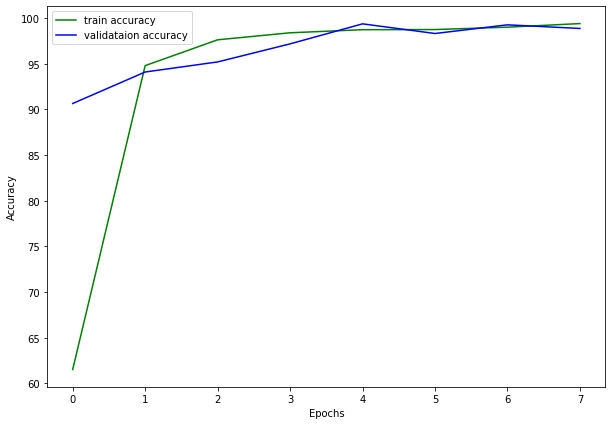

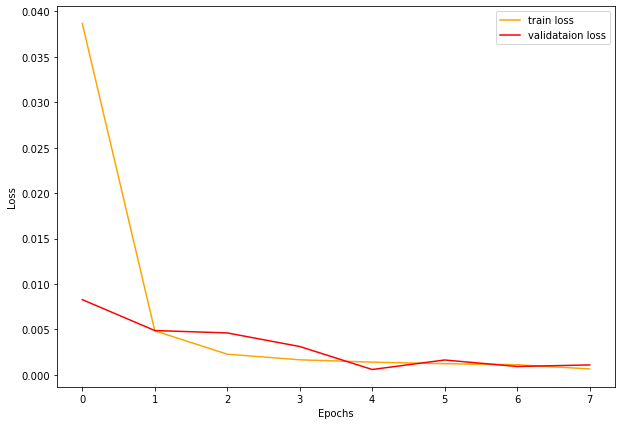

Saving model...


In [9]:
'''
USAGE:
python train.py --epochs 10
'''
import pandas as pd
import joblib
import numpy as np
import torch
import random
import albumentations
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import time
import cv2
import cnn_models
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# construct the argument parser and parse the arguments

num_epoch=int(input("Enter the number of epochs"))
''' SEED Everything '''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")


# ### Reading and preparing train and validation set
# 

# In[ ]:


# read the data.csv file and get the image paths and labels
df = pd.read_csv('ASL/input/data.csv')
X = df.image_path.values
y = df.target.values
(xtrain, xtest, ytrain, ytest) = (train_test_split(X, y, 
                                test_size=0.15, random_state=42))
print(f"Training on {len(xtrain)} images")
print(f"Validationg on {len(xtest)} images")


# ### custom dataset module
# 

# In[ ]:


# image dataset module
class ASLImageDataset(Dataset):
    def __init__(self, path, labels):
        self.X = path
        self.y = labels
        # apply augmentations
        self.aug = albumentations.Compose([
            albumentations.Resize(224, 224, always_apply=True),
        ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = cv2.imread(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

train_data = ASLImageDataset(xtrain, ytrain)
test_data = ASLImageDataset(xtest, ytest)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
testloader = DataLoader(test_data, batch_size=32, shuffle=False)


# ### preparing our neural network

# In[ ]:


# model = models.MobineNetV2(pretrained=True, requires_grad=False)
model = cnn_models.CustomCNN().to(device)
print(model)
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")


# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss function
criterion = nn.CrossEntropyLoss()


# In[ ]:


# training function
def fit(model, dataloader):
    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss/len(dataloader.dataset)
    train_accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy




#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(test_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == target).sum().item()
        
        val_loss = running_loss/len(dataloader.dataset)
        val_accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy


# In[ ]:


train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(num_epoch):
    print(f"Epoch {epoch+1} of {num_epoch}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()


# In[ ]:


# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('ASL/output/accuracy.png')
plt.show()
 
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('ASL/output/loss.png')
plt.show()
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), 'ASL/output/model.pth')


# In[ ]:






# Testing the CNN model 

Enter the path of test imageC:\Users\SARAH\Desktop\Multivariate Stats\ASL\input\asl_alphabet_test\asl_alphabet_test\A_test.jpg
CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=29, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Model loaded
torch.Size([1, 3, 224, 224])
PREDS tensor([0])
Predicted output: A
0.046 seconds


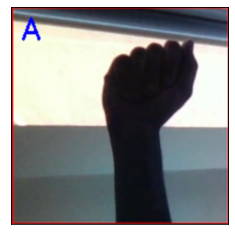

In [15]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


'''
USAGE:
python test.py --img A_test.jpg
'''
import torch
import joblib
import torch.nn as nn
import numpy as np
import cv2
import albumentations
import torch.nn.functional as F
import time
import cnn_models
# construct the argument parser and parse the arguments
test_img=input("Enter the path of test image")


aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
])


# In[ ]:


# load label binarizer
lb = joblib.load('ASL/output/lb.pkl')


# In[ ]:


model = cnn_models.CustomCNN()
model.load_state_dict(torch.load('ASL/output/model.pth'))
print(model)
print('Model loaded')


# In[ ]:


image = cv2.imread(test_img)
image_copy = image.copy()
 
image = aug(image=np.array(image))['image']
image = np.transpose(image, (2, 0, 1)).astype(np.float32)
image = torch.tensor(image, dtype=torch.float)
image = image.unsqueeze(0)
print(image.shape)


# In[ ]:


start = time.time()
outputs = model(image)
_, preds = torch.max(outputs.data, 1)
print('PREDS', preds)
print(f"Predicted output: {lb.classes_[preds]}")
end = time.time()
print(f"{(end-start):.3f} seconds")
 
cv2.putText(image_copy, lb.classes_[preds], (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

plt.imshow(image_copy, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
#cv2.imshow('image', image_copy)
#cv2.waitKey(0)



# Realtime.py

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


'''
USAGE:
python cam_test.py 
'''
import torch
import joblib
import torch.nn as nn
import numpy as np
import cv2
import torch.nn.functional as F
import time
import cnn_models
 
# load label binarizer
lb = joblib.load('ASL/output/lb.pkl')
model = cnn_models.CustomCNN()
model.load_state_dict(torch.load('ASL/output/model.pth'))
print(model)
print('Model loaded')


# In[ ]:


def hand_area(img):
    hand = img[100:324, 100:324]
    hand = cv2.resize(hand, (224,224))
    return hand


# In[ ]:


cap = cv2.VideoCapture(0)
if (cap.isOpened() == False):
    print('Error while trying to open camera. Plese check again...')
# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
# define codec and create VideoWriter object
out = cv2.VideoWriter('ASL/output/asl.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (frame_width,frame_height))


# In[ ]:


while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    # get the hand area on the video capture screen
    cv2.rectangle(frame, (100, 100), (324, 324), (20, 34, 255), 2)
    hand = hand_area(frame)
    image = hand
    
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    image = torch.tensor(image, dtype=torch.float)
    image = image.unsqueeze(0)
    
    outputs = model(image)
    _, preds = torch.max(outputs.data, 1)
    
    cv2.putText(frame, lb.classes_[preds], (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
    cv2.imshow('image', frame)
    out.write(frame)
    # press `q` to exit
    if cv2.waitKey(27) & 0xFF == ord('q'):
        break
# release VideoCapture()
cap.release()
# close all frames and video windows
cv2.destroyAllWindows()

